# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [23]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

import sklearn.model_selection
from scipy.stats import randint as sp_randint

In [24]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego. 

X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")
display(X)
display(y)

# Descomentar si quieren ver los datos para la competencia:
display(X_competencia) 
display(y_competencia_ejemplo)


X_competencia.describe()

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
501,0.2828,2.0610,1.0889,-0.7976,0.6819,-0.0531,0.3860,...,0.6734,0.3584,1.0187,1.4373,-0.7069,0.9051,-0.5420
502,-1.1895,1.1622,0.4257,0.7102,0.2699,1.1044,1.7634,...,-2.1822,0.0875,-0.6501,-1.7537,0.6584,-0.4861,-0.6913
503,-0.2730,-0.2018,0.4408,-1.0598,-0.3892,2.5573,0.1915,...,2.5449,-1.1552,1.0447,-0.6057,-2.2056,-0.4326,-0.2387
504,0.2006,0.5208,0.0377,-0.0886,1.5035,-1.6581,-1.1057,...,-1.7424,-0.5942,0.0929,0.4501,1.7539,-0.3211,2.0208
505,-0.6236,-1.2563,-0.4989,-2.3673,0.6763,-1.3346,0.9431,...,-0.5637,0.5153,0.2446,2.4462,0.3621,-0.2002,0.2214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.1862,-0.4901,0.4467,0.0266,-0.4089,0.6472,0.3563,...,-0.4666,-1.9118,-0.0137,-0.5356,-1.5728,1.0976,-0.1557
4996,0.3290,-0.1691,-1.0451,-1.1327,-0.7251,1.8375,1.0902,...,1.2854,-1.6045,0.1122,-0.4087,0.8175,-0.2249,0.6526
4997,-1.6937,-0.1262,-0.3666,-0.5854,0.1751,0.0770,0.0218,...,-0.4626,-1.1507,-0.1373,-0.7572,0.4323,-1.0987,-1.2257


,output
index,
501,0.9122
502,0.4295
503,0.6675
504,0.8060
505,0.0661
...,...
4995,0.4022
4996,0.0091
4997,0.2368


,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
count,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000,...,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000,4499.0000
mean,-0.0148,0.0082,-0.0019,0.0092,-0.0055,0.0071,-0.0106,...,0.0045,0.0142,-0.0112,-0.0043,0.0192,0.0060,-0.0160
std,1.0191,0.9992,1.0000,1.0080,0.9973,0.9926,0.9875,...,1.0079,1.0035,0.9993,0.9958,1.0041,1.0000,0.9930
min,-3.6533,-3.6325,-3.3637,-3.5548,-3.2302,-3.3062,-3.4344,...,-3.4429,-3.5572,-3.8216,-3.6234,-3.6098,-3.4736,-4.1283
25%,-0.7011,-0.6602,-0.6785,-0.6559,-0.6703,-0.6686,-0.6671,...,-0.6816,-0.6415,-0.6925,-0.6693,-0.6555,-0.6539,-0.6520
50%,-0.0066,0.0072,0.0028,-0.0024,-0.0194,-0.0009,-0.0162,...,-0.0029,0.0369,-0.0252,-0.0131,0.0319,0.0008,-0.0158
75%,0.6728,0.6827,0.6602,0.6818,0.6474,0.6871,0.6593,...,0.6630,0.6765,0.6665,0.6777,0.6791,0.6611,0.6455
max,4.0339,3.9616,3.7862,4.0113,3.8407,3.5262,3.3133,...,3.7768,3.8693,3.6974,3.4109,3.9651,3.5566,3.7533


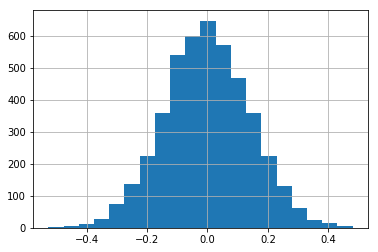

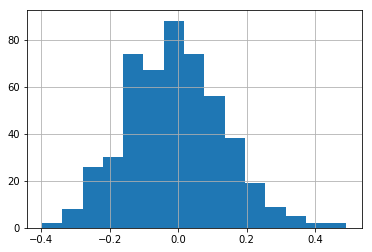

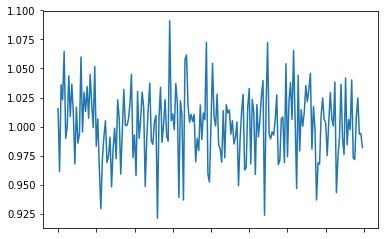

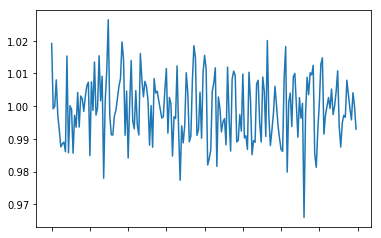

In [25]:
#Analisis de los datos
## Compararemos algunas medidas de los datos con los de la competencia para ver que se 
## parezcan lo mas posible, de esta manera forzar un overfitting con los datos de la competencia

X_competencia.mean(axis=1).hist(bins=20)
plt.show()
X.mean(axis=1).hist(bins=15)
plt.show()
X.std().plot()
plt.show()
X_competencia.std().plot()


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

X_dev: (375, 200), y_dev: (375, 1) para desarrollo
X_eval: (125, 200), y_eval: (125, 1) para evaluación


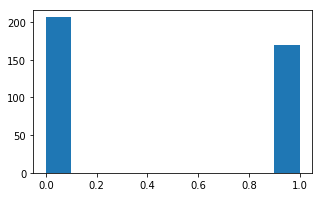

,output,%
output,,
0,271,0.542
1,229,0.458


,output,%
output,,
0,206,0.5493
1,169,0.4507


,output,%
output,,
0,65,0.52
1,60,0.48


In [26]:
# EJERCICIO 1. 

np.random.seed(1234)


########################################################
## AQUI VA SU CODIGO
X_dev, X_eval, y_dev, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=0.25)# cambiar esta línea si lo consideran necesario

# Objetivo: variables X_dev, X_eval, y_dev e y_eval asignadas
#########################################################


print("X_dev: {}, y_dev: {} para desarrollo".format(X_dev.shape, y_dev.shape))
print("X_eval: {}, y_eval: {} para evaluación".format(X_eval.shape, y_eval.shape))

plt.figure(figsize=(5, 3))
plt.hist(np.array(y_dev))  # muestra un histograma para la distribución de y.
plt.show()


def porcentajes(df,columna):
    d = df.groupby(columna).agg({columna:"count"})
    d['%'] = d[columna]/d[columna].sum()
    return d

display(porcentajes(y,"output"))
display(porcentajes(y_dev,"output"))
display(porcentajes(y_eval,"output"))


#X_dev.plot(use_index=True, kind="hist")
#X_competencia.mean().plot()
#plt.show()

#X_dev.std().plot()
#X_competencia.std().plot()

## Explicacion ejercicio 1

Elegimos dividir los datos de manera **aleatoria** para no introducir ningun tipo de desbalanceo entre ellos. Como no podemos asumir nada de los datos a simple vista basta asegurarnos que queden *mas o menos* en la misma proporcion que en los datos originales.

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.   **

----

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8367,0.6667,0.8293,0.6537
2,0.8167,0.6800,0.8061,0.6653
3,0.8633,0.6667,0.8647,0.6645
4,0.8300,0.7200,0.8190,0.7126
5,0.8433,0.7067,0.8435,0.7054


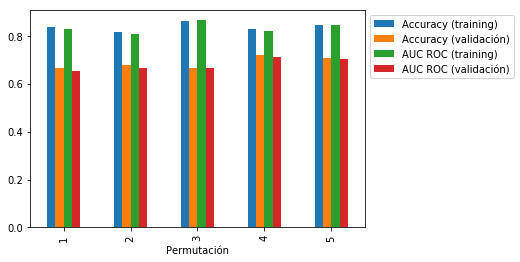

In [27]:
accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

# Puede serles de utilidad tener a X_dev e y_dev como matrices de numpy directamente:
X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

########################################################
## AQUI VA SU CODIGO 
## Objetivo: accuracies_training, accuracies_validation, aucs_training y aucs_validation asignados
#########################################################
arbol = sklearn.tree.DecisionTreeClassifier(max_depth=3)
kf = sklearn.model_selection.KFold(n_splits=5)



for train_index, test_index in kf.split(X_dev_np,y_dev_np):
    X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
    y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]
    
    arbol.fit(X_train, y_train)
    y_pred_train = arbol.predict(X_train)
    y_pred_test = arbol.predict(X_test)
    
    sc_train = arbol.score(X_train, y_train)
    accuracies_training.append(sc_train)
    
    sc_test = arbol.score(X_test, y_test)
    accuracies_validation.append(sc_test)
    
    auc_train = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
    aucs_training.append(auc_train)
    
    auc_test = sklearn.metrics.roc_auc_score(y_test, y_pred_test)
    aucs_validation.append(auc_test)
  
df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
df["Accuracy (training)"] = accuracies_training
df["Accuracy (validación)"] = accuracies_validation
df["AUC ROC (training)"] = aucs_training
df["AUC ROC (validación)"] = aucs_validation


display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
df.plot(kind="bar")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [28]:
resultados_training = []
resultados_validation = []

########################################################
## AQUI VA SU CODIGO 
## Objetivo: resultados_training y resultados_validation asignadas
#
## Recomendamos seguir el siguiente esquema:
# np.random.seed(SEED)
# for criterio in ["gini", "entropy"]:
#     for altura in [3, 5, None]:
#         CODIGO AQUI.
#         resultados_training.append( <RESULTADO_TRAINING> )
#         resultados_validation.append( <RESULTADO_VALIDATION> )
#########################################################

np.random.seed(SEED)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_dev, y_dev, test_size=0.2)

for criterio in ["gini", "entropy"]:
    for altura in [3, 5, None]:
        arbol = sklearn.tree.DecisionTreeClassifier(max_depth=altura,criterion=criterio)
        arbol.fit(X_train, y_train)
        y_pred_train = arbol.predict(X_train)
        y_pred_test = arbol.predict(X_test)
        
        auc_train = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
        resultados_training.append(auc_train)
    
        auc_test = sklearn.metrics.roc_auc_score(y_test, y_pred_test)
        resultados_validation.append(auc_test)


df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"] = resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8360,0.6232
1,5,Gini,0.9591,0.6482
2,Inifinito,Gini,1.0000,0.5821
3,3,Ganancia de Información,0.8244,0.6232
4,5,Ganancia de Información,0.9659,0.6464
5,Inifinito,Ganancia de Información,1.0000,0.6464


In [29]:
# EJERCICIO EXTRA

from notebook_4_implementacion_arboles import MiClasificadorArbol

def ejercicioExtra():
    accuracies_training = []
    accuracies_validation = []
    aucs_training = []
    aucs_validation = []

    X_dev_np = np.array(X_dev)
    y_dev_np = np.array(y_dev).ravel()

    arbol = MiClasificadorArbol(list(range(X_dev_np.shape[1])),3, "gini")
    kf = sklearn.model_selection.KFold(n_splits=5)
    
    for train_index, test_index in kf.split(X_dev_np,y_dev_np):
        X_train, X_test = X_dev_np[train_index], X_dev_np[test_index]
        y_train, y_test = y_dev_np[train_index], y_dev_np[test_index]
        
        arbol.fit(X_train, y_train)
        y_pred_train = arbol.predict(X_train)
        y_pred_test = arbol.predict(X_test)
        
        sc_train = arbol.score(X_train, y_train)
        accuracies_training.append(sc_train)
        
        sc_test = arbol.score(X_test, y_test)
        accuracies_validation.append(sc_test)
        
        auc_train = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
        aucs_training.append(auc_train)
        
        auc_test = sklearn.metrics.roc_auc_score(y_test, y_pred_test)
        aucs_validation.append(auc_test)
        
    df = pd.DataFrame(index=range(1,6))
    df.index.name = "Permutación"
    df["Accuracy (training)"] = accuracies_training
    df["Accuracy (validación)"] = accuracies_validation
    df["AUC ROC (training)"] = aucs_training
    df["AUC ROC (validación)"] = aucs_validation


    display(HTML("<h3> TABLA 1 </h3>"))
    display(df)


    resultados_training = []
    resultados_validation = []

    np.random.seed(SEED)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_dev, y_dev, test_size=0.2)

    X_train_np = np.array(X_train)
    y_train_np = np.array(y_train).ravel()
    X_test_np = np.array(X_test)
    y_test_np = np.array(y_test).ravel()
    
    for crit in ["gini", "entropy"]:
        for altura in [3, 5, -1]:
            arbol = MiClasificadorArbol(list(range(X_train_np.shape[1])),altura,crit)
            arbol.fit(X_train_np, y_train_np)
            y_pred_train = arbol.predict(X_train_np)
            y_pred_test = arbol.predict(X_test_np)
            
            auc_train = sklearn.metrics.roc_auc_score(y_train_np, y_pred_train)
            resultados_training.append(auc_train)
        
            auc_test = sklearn.metrics.roc_auc_score(y_test_np, y_pred_test)
            resultados_validation.append(auc_test)


    df = pd.DataFrame(index=range(0,6))

    df["Altura máxima"] = [3, 5, "Inifinito"] * 2
    df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
    df["AUC ROC promedio (training)"] = resultados_training
    df["AUC ROC promedio (validación)"] = resultados_validation

       
    display(HTML("<h3> TABLA 2 </h3>"))
    display(df)
    
# import time
# time1 = time.time()
# ret = ejercicioExtra()
# time2 = time.time()
# print('{:s} tardo {:.3f} ms'.format("Ejercicio Extra", (time2-time1)*1000.0))

# Ejercicio Extra

Para este ejercicio decidimos hacer una copia del notebook 4 y utilizarlo con un import para no copiar todo el codigo al notebook del Trabajo.

Las modificaciones que hicimos son las siguientes:
   1. Cambiamos la metodologia de las preguntas, que comparaban con == a >=.
   2. Cambiamos la implementacion para que tome los datos como numpy arrays en vez de DataFrames y eso cambio considerablemente los tiempos de ejecucion
   3. Agregamos parametros al clasificador para que se pueda optar por elegir Gini o Entropia para el calculo de ganancia, y tambien delimitar la profundidad
   4. Cambiamos el criterio para encontrar puntos de corte: En el Mitchell (Capitulo 3 pagina 72) explica que lo que hace es ordenar la columna, agarrar los pares de datos donde cambia la etiqueta (de 0 a 1 o viceversa) y agarra el promedio de los dos puntos como posible corte.

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

def top_resultados(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones por validación".format(top))
    df = pd.DataFrame(list(grid.cv_results_["params"]))
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))
    
    
def top_resultados_training(grid, top=5):
    ## Si quieren, pueden utilizar esta función para imprimir las mejores combinaciones de su grid
    print("Top {} combinaciones por entrenamiento".format(top))
    df = pd.DataFrame(list(grid.cv_results_["params"]))
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_training", ascending=False).head(top))

########################################################
## AQUI VA SU CODIGO 
## Objetivo: comparar y explorar distintas combinaciones de parámetros para los algoritmos importados arriba
########################################################

np.random.seed(SEED)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_dev, y_dev, test_size=0.2)
c, r = y_train.shape
y_train = y_train.values.reshape(c,)
c, r = y_test.shape
y_test = y_test.values.reshape(c,)

Procedemos a analizar los mejores modelos obtenidos modificando sus hiperparámetros a través de GridSearch.

## Árbol de decisión

In [31]:
parametros_arbol = {"criterion":["entropy", "gini"], 'max_depth':np.arange(1,100)}
grid_arbol = GridSearchCV(DecisionTreeClassifier(), parametros_arbol, cv=5, scoring="roc_auc")
grid_arbol.fit(X_train, y_train)
top_resultados_training(grid_arbol, top=5)
top_resultados(grid_arbol, top=5)

Top 5 combinaciones por entrenamiento


,criterion,max_depth,mean_score_validation,mean_score_training
197,gini,99,0.6003,1.0
137,gini,39,0.6135,1.0
128,gini,30,0.6271,1.0
129,gini,31,0.6187,1.0
130,gini,32,0.6118,1.0


Top 5 combinaciones por validación


,criterion,max_depth,mean_score_validation,mean_score_training
1,entropy,2,0.7162,0.8368
2,entropy,3,0.7145,0.9170
100,gini,2,0.7030,0.8402
0,entropy,1,0.6766,0.7320
99,gini,1,0.6766,0.7320


Comenzamos analizando la performance de los árboles de decisión. Observamos con extrañeza que los 5 mejores modelos evaluados por AUC ROC en la validación resultan ser de muy baja profundidad: A pesar de haber corrido con el rango [1..100], tenemos árboles de profundidad 1 entre los mejores modelos, y no superan la altura 4.
    
Sin embargo, observando la tabla de mejores resultados de entrenamiento, recordamos que los árboles de decisión son propensos a hacer overfitting - cuanto más profundidad peor - y consideramos entonces que las alturas de los mejores modelos son bajas porque con más altura el modelo se vuelve demasiado propenso a overfitting.

Consideramos, además, que en este caso no parece haber gran diferencia entre medir impureza con gini o con entropía.

## kNN

In [32]:
parametros_knn = {"weights":["uniform", "distance"], 'n_neighbors':np.arange(1,200)}
grid_knn = GridSearchCV(KNeighborsClassifier(), parametros_knn, cv=5, scoring="roc_auc")
grid_knn.fit(X_train, y_train)
top_resultados(grid_knn, top=5)
top_resultados_training(grid_knn, top=5)

Top 5 combinaciones por validación


,n_neighbors,weights,mean_score_validation,mean_score_training
107,54,distance,0.8465,1.0
109,55,distance,0.8458,1.0
133,67,distance,0.8452,1.0
129,65,distance,0.8442,1.0
135,68,distance,0.8440,1.0


Top 5 combinaciones por entrenamiento


,n_neighbors,weights,mean_score_validation,mean_score_training
0,1,uniform,0.6644,1.0
231,116,distance,0.8342,1.0
203,102,distance,0.8418,1.0
205,103,distance,0.8404,1.0
207,104,distance,0.8395,1.0


## LDA

In [33]:
parametros_lda = {"n_components":np.arange(1,20)}
grid_lda = GridSearchCV(LinearDiscriminantAnalysis(), parametros_lda, cv=5, scoring="roc_auc")
grid_lda.fit(X_train, y_train)
top_resultados(grid_lda, top=5)

Top 5 combinaciones por validación


,n_components,mean_score_validation,mean_score_training
0,1,0.6157,1.0
10,11,0.6157,1.0
17,18,0.6157,1.0
16,17,0.6157,1.0
15,16,0.6157,1.0


## GaussianNB

In [34]:
priors = list(zip(np.linspace(0.1,0.9,81),np.linspace(0.9,0.1,81)))
parametros_gauss = {"priors":priors}
grid_gauss = GridSearchCV(GaussianNB(), parametros_gauss, cv=5, scoring="roc_auc")
grid_gauss.fit(X_train, y_train)
top_resultados(grid_gauss, top=5)

Top 5 combinaciones por validación


,priors,mean_score_validation,mean_score_training
6,"(0.16, 0.8400000000000001)",0.8347,0.8872
7,"(0.17, 0.8300000000000001)",0.8347,0.8872
8,"(0.18, 0.8200000000000001)",0.8347,0.8872
9,"(0.19, 0.81)",0.8347,0.8872
11,"(0.21000000000000002, 0.79)",0.8346,0.8872


## LinearSVC

In [35]:
parametros_lineal = {"C": [pow(10,x) for x in range(-15,5)]}
grid_lineal = GridSearchCV(LinearSVC(), parametros_lineal, cv=5, scoring="roc_auc")
grid_lineal.fit(X_train, y_train)
top_resultados_training(grid_lineal, top=5)
top_resultados(grid_lineal, top=5)

Top 5 combinaciones por entrenamiento


,C,mean_score_validation,mean_score_training
19,10000.0,0.7621,1.0
18,1000.0,0.7621,1.0
17,100.0,0.7621,1.0
16,10.0,0.7623,1.0
15,1.0,0.7617,1.0


Top 5 combinaciones por validación


,C,mean_score_validation,mean_score_training
11,1.0000e-04,0.8377,0.8903
12,1.0000e-03,0.8373,0.9697
10,1.0000e-05,0.8292,0.8643
6,1.0000e-09,0.8285,0.8606
1,1.0000e-14,0.8285,0.8606


**En cuanto a Linear SVC**, tenemos en cuenta que el factor C controla el grado de clasificación errónea de los datos de entrenamiento, mediante el tamaño del margen y la cantidad de puntos que se permiten sin respetar la clasificación del hiperplano. Cuando C es chico, el margen se agranda, con muchas observaciones sin respetar el margen propuesto. En este caso obtenemos un clasificador que 'fittea' más suavemente sobre los datos, con más sesgo y menos varianza. Cuando el parámetro C es grande, buscamos márgenes más finos, que casi no permite ser traspasado por alguna observación. Esto produce un clasificador con bajo sesgo pero alta varianza.

Nos resultó importante chequear empíricamente este análisis teórico de C, y se ve reflejado en los resultados obtenidos: Al ordenar por mejores resultados de training, resulta ser que un margen muy angosto funciona mucho mejor - a costa de cierto overfitting: tenemos un peor resultado de validación debido a la alta varianza antes mencionada. Mientras tanto, al ordenar por resultados de validación, resulta ser que un margen más grande funciona mejor: El sesgo de entrenamiento aumenta, pero la varianza es baja y no se overfittean los datos: el modelo está mucho más adaptado para evaluar correctamente a los nuevos datos de validación.

Finalmente notamos que en el caso de evaluar por datos de entrenamiento el modelo se queda con el C más grande y exagerado (10^5), mientras que por datos de validación se quedó con uno intermedio (10^-3).

## Conclusiones ejercicio 3:

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----




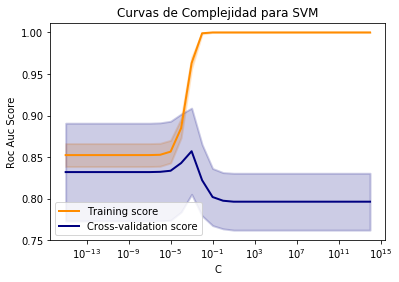

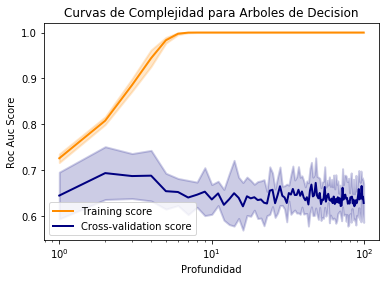

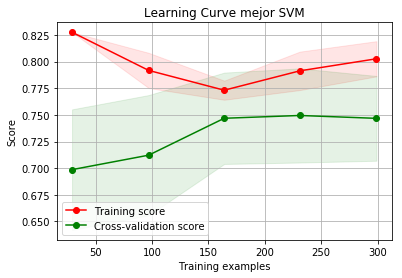

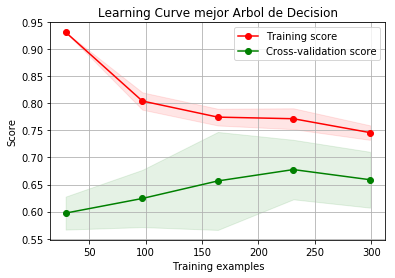

In [36]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve


mejorSVM = grid_lineal.best_estimator_
mejorDecisionTree = grid_arbol.best_estimator_

def plot_learning_curve(estimator, title, X, y, cv=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


def plot_validation_curve(estimator, X, y, param, paramRange, plotTitle, parametroName):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param, param_range=paramRange,
        cv=5, scoring="roc_auc")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(plotTitle)
    plt.xlabel(parametroName)
    plt.ylabel("Roc Auc Score")
    lw = 2
    plt.semilogx(paramRange, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(paramRange, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(paramRange, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(paramRange, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

plot_validation_curve(mejorSVM,X_dev_np, y_dev_np, "C", [pow(10,x) for x in range(-15,15)],
                      "Curvas de Complejidad para SVM", "C")
plot_validation_curve(mejorDecisionTree,X_dev_np, y_dev_np, "max_depth", range(1,100),
                      "Curvas de Complejidad para Arboles de Decision", "Profundidad")


plot_learning_curve(mejorSVM, "Learning Curve mejor SVM", X_dev_np, y_dev_np, cv=5)
plot_learning_curve(mejorDecisionTree, "Learning Curve mejor Arbol de Decision", X_dev_np, y_dev_np, cv=5)


## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
